# Laboratorio 3.1: Clasificación

Profesoras de Cátedra: Jazmine Maldonado, Cinthia Sánchez Profesores Auxiliares: Fran Zautzik, María José Zambrano

Septiembre 2023


## Nombres

* Andrés Calderón
* Franco González

## Instrucciones

1. Trabajen en equipos de dos personas. Salvo excepciones, no se corregirá entregas con menos de dos integrantes.

2. Modifique este archivo `.ipynb` agregando sus respuestas donde corresponda.

3. El formato de entrega para esta actividad es un archivo **html**. Genere un archivo HTML usando jupyter (ver tutorial 2) y súbalo a U-Cursos. Basta con que **uno de los integrantes haga la entrega**. Si ambos hacen una entrega en U-Cursos, se revisará cualquiera de éstas.


A continuación vamos a cargar un dataset con noticias, el cual se puede encontrar en: https://www.kaggle.com/datasets/kevinmorgado/spanish-news-classification.

Los atributos que posee son:

- URL : El link a la noticia
- News: El texto de la noticia
- Type: La clasificación de la noticia


Para el laboratoria solo nos importan las columnas News y Type.


In [7]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mzambrano1/Datasets-CC5205-otono-2023/master/lab2.1/noticias.csv")
df = df[["news", "Type"]]
df = df.rename(columns={
    'news': 'Noticia', 'Type':'Clasificación'})
df.head()


,Noticia,Clasificación
0,Durante el foro La banca articulador empresari...,Otra
1,El regulador de valores de China dijo el domin...,Regulaciones
2,En una industria históricamente masculina como...,Alianzas
3,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,Ayer en Cartagena se dio inicio a la versión n...,Otra


A continuación preprocesaremos los textos y los convertiremos en vectores. Esto con el propósito de tener información numérica que pueda ser interpretable por los modelos que crearemos después.


In [8]:
import requests
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

def remove_numbers(text):
    text = re.sub(r"[0-9]", " ", text)
    return " ".join(text.split())


def remove_unprintable_(text):
    printable = set(string.printable + "ñáéíóúü" + "ÑÁÉÍÓÚÜ")
    text = "".join(filter(lambda x: x in printable, text))
    return text

def remove_punctuation(text):
    pattern = re.compile(r"[^\w\sáéíóúüñÁÉÍÓÚÜÑ]")
    t = pattern.sub(r" ", text)
    return re.sub(" +", " ", t)


def reduce_spam(text):
    text = re.sub(r"(\w+)(\s+\1){2,}", r"\1", text)
    text = re.sub(r"(\w+\s+\w+)(\s+\1){2,}", r"\1", text)
    return text


def remove_vowels_accents(text):
    return (
        text.replace("á", "a")
        .replace("é", "e")
        .replace("í", "i")
        .replace("ó", "o")
        .replace("ú", "u")
        .replace("ü", "u")
    )

def remove_stopwords(text, stopwords_list):
    return " ".join(
        [word for word in str(text).split() if word not in stopwords_list]
    )

url = "https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt"
r = requests.get(url)

stopwords_list = r.text.splitlines()

def preprocesar(text):
    text = text.lower()
    text = remove_numbers(text)
    text = remove_unprintable_(text)
    text = remove_punctuation(text)
    text = reduce_spam(text)
    text = remove_stopwords(text, stopwords_list)
    text = remove_vowels_accents(text)
    return text.strip()


# Extraer los vectores
vectorizer = CountVectorizer(preprocessor=preprocesar, min_df=2)
vectors = vectorizer.fit_transform(df["Noticia"])

# Incorporar los vectores como dataframe
X = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
y = df["Clasificación"]

df_vectorizado = pd.concat([y, X], axis=1)
df_vectorizado.head()


,Clasificación,aa,aaa,abacum,abajo,abandonar,abandono,abanico,abaratamiento,abaratar,...,zero,zhao,zijin,zmvm,zona,zonas,zuckerberg,zug,zuluaga,zurich
0,Otra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Regulaciones,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alianzas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Macroeconomia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Otra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pregunta 1

Cargue los datos e indique lo siguiente:

- Tamaño del dataset vectorizado (cantidad de instancias y atributos).
- ¿Cuántas clases hay en la columna "Clasificación" y cuáles son sus nombres?
- ¿Cuántas instancias hay en cada clase?

Indique en cada caso cómo obtuvo la respuesta, es decir, adjunte código.


In [23]:
#Respuesta
print("Dimensiones del dataset:", df_vectorizado.shape, "\n")
print("Cantidad de clases:", len(df_vectorizado["Clasificación"].unique()))
print("Clases:", df_vectorizado["Clasificación"].unique(), "\n")
print("Cantidad de elementos por clase:\n", df_vectorizado["Clasificación"].value_counts())

Dimensiones del dataset: (1217, 14407) 

Cantidad de clases: 7
Clases: ['Otra' 'Regulaciones' 'Alianzas' 'Macroeconomia' 'Innovacion'
 'Sostenibilidad' 'Reputacion'] 

Cantidad de elementos por clase:
 Clasificación
Macroeconomia     340
Alianzas          247
Innovacion        195
Regulaciones      142
Sostenibilidad    137
Otra              130
Reputacion         26
Name: count, dtype: int64


### Pregunta 2


En esta parte useremos el clasificador **Decision Tree**. Veremos distintas formas de usarlo, y vamos a compararlas utilizando diversas métricas.


Usando el siguiente código, entrenaremos un clasificador con los datos cargados (X, y) y haremos una predicción sobre los mismos datos empleando dicho clasificador entrenado. Luego, se mostrarán las métricas de **accuracy**, **precision**, **recall** y **f1-score**.


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

Accuracy: 0.9967132292522597
                precision    recall  f1-score   support

      Alianzas       0.99      1.00      0.99       247
    Innovacion       1.00      1.00      1.00       195
 Macroeconomia       1.00      1.00      1.00       340
          Otra       1.00      0.98      0.99       130
  Regulaciones       1.00      0.99      1.00       142
    Reputacion       1.00      1.00      1.00        26
Sostenibilidad       1.00      0.99      1.00       137

      accuracy                           1.00      1217
     macro avg       1.00      1.00      1.00      1217
  weighted avg       1.00      1.00      1.00      1217



De acuerdo a los resultados obtenidos:

- ¿Qué opina sobre las predicciones?

- ¿Qué problema puede identificar?


**Respuesta:**

Las métricas son tan altas que nos hacen dudar del test con el que se probó el modelo.

Primero podemos notar que se utilizaron los mismos datos de entrenamiento para el testeo del modelo, por lo que este tiene muy buenos resultados con estos, pero probablemente no obtenga resultados tan buenos con datos con los que no ha trabajado anteriormente.

### Pregunta 3.1


Ahora lo que haremos será dividir nuestro dataset en 70% entrenar (**_training set_**) y 30% para testear (**_testing set_**). Use la función **_train_test_split()_** de _sklearn_ y utilice las variables `X_train, X_test, y_train, y_test`.


Escriba el código necesario para dividir los datos, entrenar el modelo e indicar el **accuracy**, **precision** y **recall** del clasificador.

Entrene usando el **_training set_** y pruebe sobre el **_testing set_**, en base a la división 70%-30%, respectivamente

**NOTA: para dividir el dataset use el parámetro `stratify=y`.**


In [26]:
# Recuerde usar las variables X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(np.mean(y_pred["accuracy"]))
print(np.mean(y_pred["precision"]))
print(np.mean(y_pred["recall"]))

Accuracy: 0.7978142076502732
                precision    recall  f1-score   support

      Alianzas       0.82      0.86      0.84        74
    Innovacion       0.81      0.86      0.84        59
 Macroeconomia       0.75      0.90      0.82       102
          Otra       0.76      0.67      0.71        39
  Regulaciones       0.86      0.58      0.69        43
    Reputacion       0.86      0.75      0.80         8
Sostenibilidad       0.85      0.68      0.76        41

      accuracy                           0.80       366
     macro avg       0.82      0.76      0.78       366
  weighted avg       0.80      0.80      0.79       366



### Pregunta 3.2.

¿Qué opina sobre las predicciones obtenidas en la pregunta anterior?

Responda lo siguiente:

1. Comparando los clasificadores de las preguntas 2 y 3 ¿Cuál tiene peores resultados? ¿Por qué?
2. ¿Cuál de las dos formas de entrenar el clasificador prefiere? Justifique su respuesta


**Respuesta:**

No son tan buenas como la de la situación anterior, pero se puede notar que en esta ocasión el modelo si tuvo un aprendizaje de los datos en vez de memorizarlos.

Númericamente los resultados del segundo modelo son peores pero esto se debe a que en esta ocasión utilizamos datos desconocidos para el modelo durante el entrenamiento al momento de realizar el testeo, y probablemente este modelo obtendría mejores resultados para datos nuevos pues sería más generalizable.

La forma correcta de entrenar modelos es usando datos desconocidos durante el testeo para que al momento de revisar los resultados obtengamos valores más realistas, por lo que elegiriamos el segundo dado que si podemos visualizar de forma efectiva unos resultados que se corresponden más con lo esperado.

### Pregunta 4

El siguiente código genera una matriz de confusión de los resultados de clasificación de la pregunta anterior. Ejecute el bloque completo para visualizar el gráfico. Interprete la matriz y comente sobre cada uno de los valores distintos de 0 en la matriz y describa lo que representa.

_Verifique que los resultados que se imprimen concuerden con su respuesta (por el factor aleatorio del estimador). Nota: Para obtener un comportamiento determinista existe el parámetro **random_state**, por ejemplo: clf = DecisionTreeClassifier(random_state=2)._


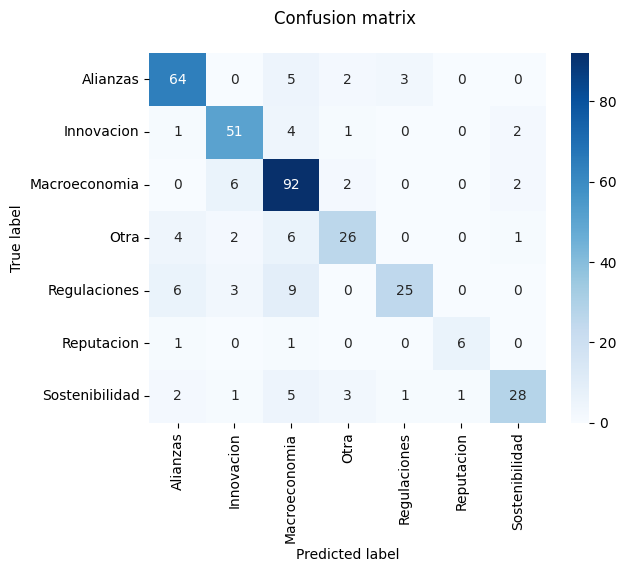

In [30]:
# EJECUTAR ESTE BLOQUE
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute confusion matrix. By default is not normalized (normalize=None)
# If necessary change 'y_pred' according to your variable name
cm = confusion_matrix(y_test, y_pred)

# Only use the labels that appear in the data
classes = unique_labels(y_test, y_pred)

df = pd.DataFrame(cm, index=classes, columns=classes)

g = sns.heatmap(df, annot=True, cmap="Blues")
g.set_yticklabels(g.get_yticklabels(), rotation=0)

plt.title('Confusion matrix \n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.autoscale()


**Respuesta:**

Como la mayor parte de los datos están en la diagonal se puede notar que el modelo predice efectivamente gran parte de los datos. También podemos visualizar que los datos están desbalanceados, principalmente se observa una gran diferencia entre las clases "Macroeconomía" y "Reputación", de la cual la primera posee alrededor de 100 datos mientras que la segunda tan solo 8, lo cual no permite al modelo aprender a clasificar clases minoritarias. 

### Pregunta 5

Para este clasificador utilizaremos Cross-validation. Con cross-validation, el conjunto de entrenamiento se divide en $k$ conjuntos disjuntos; se entrena sobre los datos correspondientes a $k-1$ de éstos, y se evalúa sobre el conjunto restante. Esto se repite $k$ veces, evaluando siempre sobre un conjunto distinto. Teniendo en cuenta el parámetro $k$, a éste método se le llama $k$-fold cross-validation.

El código que está a continuación realizará 10-fold cross-validation usando Decision Tree sobre los datos. La forma de estimar el rendimiento del clasificador es, entre otras cosas, calculando el promedio de todos los k-folds.

Además se muestra la predición sobre los datos para testear.


In [32]:
# EJECUTAR ESTE BLOQUE

from sklearn.model_selection import cross_validate
import numpy as np

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']
cv_results = cross_validate(
    clf, X, y, cv=10, scoring=scoring, return_train_score=True)

print('Promedio Precision:', np.mean(cv_results['test_precision_macro']))
print('Promedio Recall:', np.mean(cv_results['test_recall_macro']))
print('Promedio F1-score:', np.mean(cv_results['test_f1_macro']))
print('Promedio Accuracy:', np.mean(cv_results['test_accuracy']))

# Si quisieramos mostrar el resultado de cada k-fold, deberiamos quitar la
# funcion np.mean la cual retorna el promedio. Esto mostraría una lista con el resultado de cada fold


Promedio Precision: 0.7965088655183358
Promedio Recall: 0.7667098013294387
Promedio F1-score: 0.7679477137029559
Promedio Accucary: 0.7863297656144155


- Compare los valores de las métricas con respecto a lo obtenido en la pregunta 3.1. Comente en qué difieren y por qué.
- ¿Qué beneficios tiene emplear cross-validation?



**Respuesta:**

Las métricas empeoraron un poco, y podemos suponer que esta diferencia es debido al overfitting dado que al utilizar más datos para el entrenamiento, como las particiones son del 90% de datos para el entrenamiento y el resto para el testeo, por lo que este modelo puede estar intentando memorizar la información más que intentar aprender algún patrón. Uno podría pensar que el modelo mejoraría al entrenarlo varias veces, pero en este caso no resultó así debido a la cantidad de particiones que se eligieron.

Por lo general, emplear cross-validation tiene el beneficio de poder utilizar todos los datos del dataset en varias etapas del proceso de aprendizaje, tanto en los datos de entrenamiento como en los de testeo. También podemos decir que el modelo resultante va a predecir en base a varios modelos resultantes, por lo que si alguno de estos estuviera sesgado, mientras este no esté presente en la mayoría, al tener varios no se notaría este sesgo en el producto final.

### Pregunta 6

Cuando hacemos clasificación en Data Mining queremos encontrar un patrón en los datos. Analice los atributos de los datos junto a los resultados obtenidos en la pregunta 3.1 y describa sus principales observaciones. ¿Cómo se relacionan los atributos X con la clase de interés y? Es una pregunta abierta, puede apoyar su análisis con tablas y/o visualizaciones.

**Respuesta:**

Una de las principales observaciones es que cada tipo de noticia utilizará un vocabulario adecuado según el contexto, por lo que deben existir palabras claves con las que el modelo podría casi asegurar que se está hablando de un cierto tema, incluyendo el nombre de este mismo, por lo que podemos suponer que existen atributos X que están fuertemente relacionados con la etiqueta.

El modelo resultante de la pregunta 3.1 probablemente realiza el procedimiento descrito, de modo que busca que el elemento analizado posea estas palabras clave, pudiendo clasificar erróneamente ciertos valores debido a la aparición de estas palabras clave para una cierta clasificación pese a que es otra.

<Axes: >

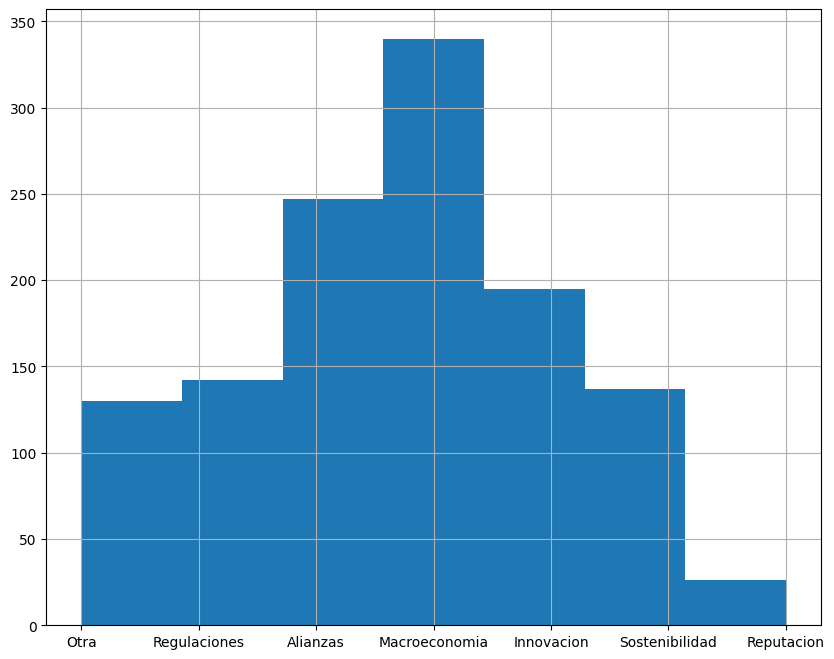

In [41]:
df_vectorizado["Clasificación"].hist(bins=7, figsize=(10, 8))

En el modelo resultante de la pregunta 3.1 se podía evidenciar un desbalance y ahora lo apoyamos con este histograma. 